In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from torch.optim import Adam
import skimage
import sklearn.metrics
import skimage.segmentation
from PIL import Image
import requests


print(torch.__version__)

1.0.1.post2


In [2]:
url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/' \
      'raw/596b27d23537e5a1b5751d2b0481ef172f58b539/imagenet1000_clsid_to_human.txt'

imagenet_classes = eval(requests.get(url).content)

trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_model = models.resnet18(pretrained=True, num_classes=1000)
_model.to(device)
_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

predicted Labrador retriever
predicted 0.5574051
predicted golden retriever
predicted 0.18797565
predicted Great Pyrenees
predicted 0.15238883
predicted kuvasz
predicted 0.033451293
predicted Cardigan, Cardigan Welsh corgi
predicted 0.012703158


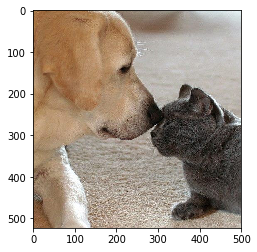

In [4]:
img_url = 'https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg'
Xi = Image.open(requests.get(img_url, stream=True).raw)
plt.imshow(Xi)

tens = (trans(Xi)).to(device)
tens = tens.view(1, 3, 224, 224)
preds = nn.Softmax(dim=-1)(_model(tens)).data.cpu().numpy()[0]
res = preds.argsort()[-5:][::-1]
#print('true (likely) label:', class_name)
for i in res:
    print('predicted', imagenet_classes[i])
    print('predicted', preds[i])

For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

60

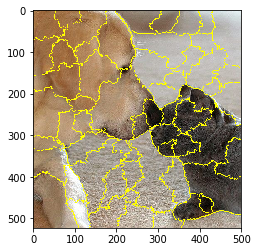

In [5]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=7,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
plt.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))
num_superpixels

In [6]:
num_perturb = 500
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

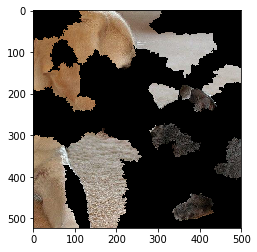

In [7]:
import copy

def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape, np.uint8)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

plt.imshow(perturb_image(Xi,perturbations[1],superpixels))

Predict the label of perturbed images (target)

In [8]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi, pert, superpixels)
    perturbed_img = transforms.ToPILImage()(perturbed_img)
    
    tens = trans((perturbed_img)).to(device)
    tens = tens.view(1, 3, 224, 224)
    preds = nn.Softmax(dim=-1)(_model(tens)).data.cpu().numpy()[0]
    predictions.append(preds)

predictions = np.array(predictions)

distance = ([1,0,1,..,0] - [1,1,1,...,1])

In [9]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

train explainable model

In [10]:
from sklearn.linear_model import LinearRegression
class_to_explain = res[0]

simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 0.00475957,  0.00313208,  0.00025112, -0.00104683,  0.008531  ,
        0.00073604,  0.01766431, -0.0015176 , -0.00632417,  0.02638595,
       -0.00399645,  0.01263488,  0.01361972, -0.00284848,  0.00279164,
        0.01427587,  0.00702693, -0.00682661,  0.01363513,  0.00567386,
        0.00623637,  0.00032019, -0.00260276,  0.00997111,  0.003502  ,
       -0.00590693,  0.01161081,  0.00068735,  0.00709014,  0.0087997 ,
        0.00584561,  0.00173416,  0.00093345,  0.00475355,  0.00086919,
        0.0030423 , -0.00558921,  0.00063997, -0.0008075 , -0.0033858 ,
       -0.00103315,  0.00899927,  0.00321692, -0.00165432,  0.00729551,
       -0.00239975, -0.00679366, -0.00034055, -0.00507067,  0.00309479,
       -0.00469223,  0.00351048,  0.00096512,  0.00154041,  0.00815814,
        0.00084233, -0.00486887,  0.00155334,  0.00616392, -0.0026552 ])

explainable super pixels = top coeff of linear regression

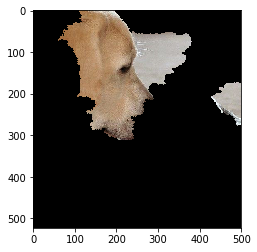

In [15]:
num_top_features = 8
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
plt.imshow(perturb_image(Xi,mask,superpixels))